In [1]:
from cloudvolume import CloudVolume
from skimage.transform import downscale_local_mean
import napari
from skimage import io
import random
import h5py
from skimage import measure
from brainlit.preprocessing import removeSmallCCs
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import tables
from napari_animation import AnimationWidget
from tqdm import tqdm
import pickle
from parse_ara import *
import networkx as nx
import seaborn as sns
from statannotations.Annotator import Annotator
import pandas as pd
import brainrender
import scipy.ndimage as ndi
from skimage.morphology import skeletonize
from axon_data import brain2paths as brain2paths_axon
from util import find_sample_names
from soma_rabies_somadetector_data import brain2paths as brain2paths_soma
import os
from util import json_to_points
import scipy.ndimage as ndi
import random
from cloudvolume import CloudVolume
%gui qt5

/Users/thomasathey/Documents/mimlab/mouselight/docs_env/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


# Axon

## Intensity Histograms

Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


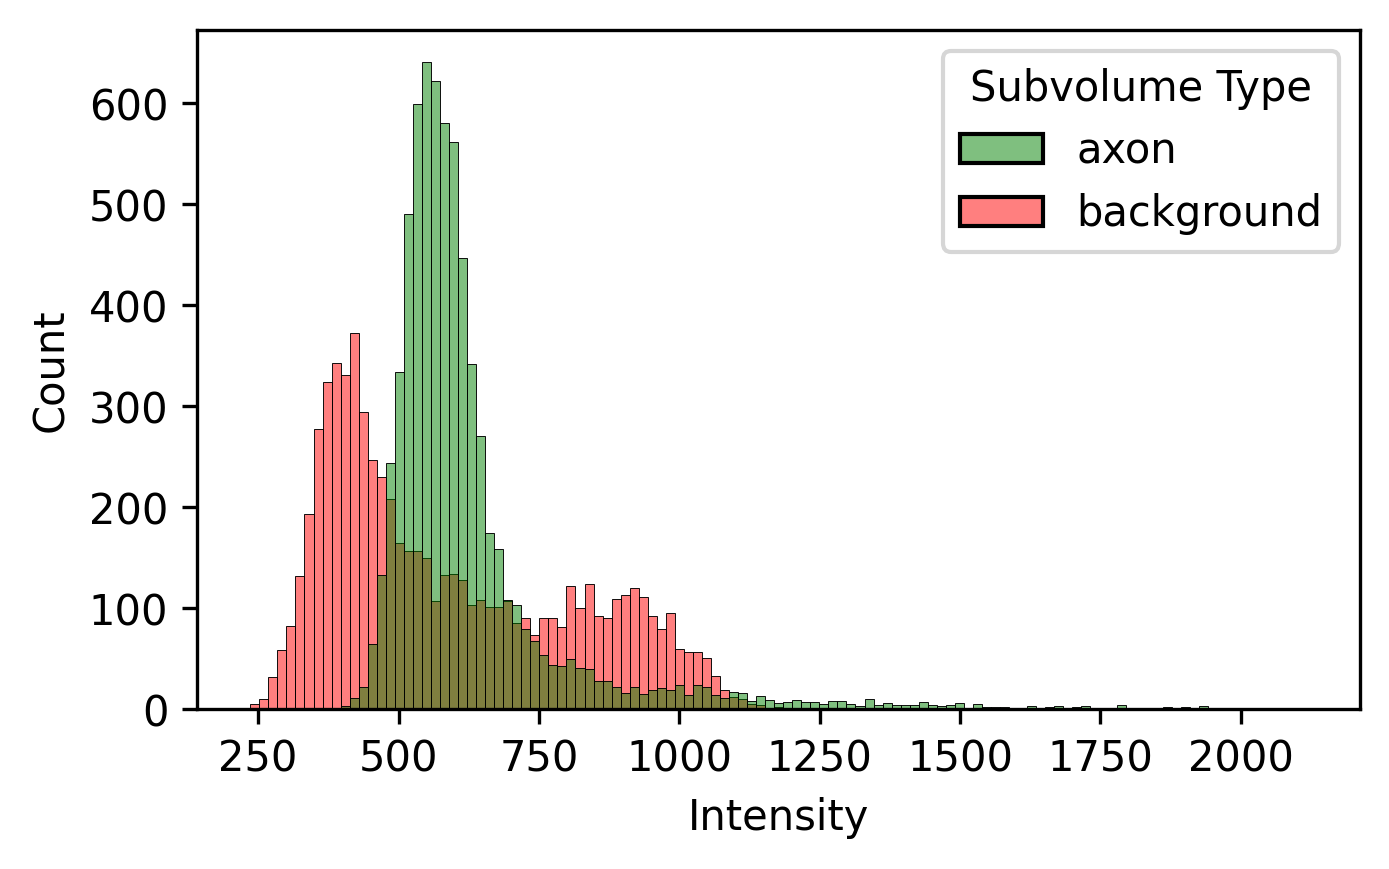

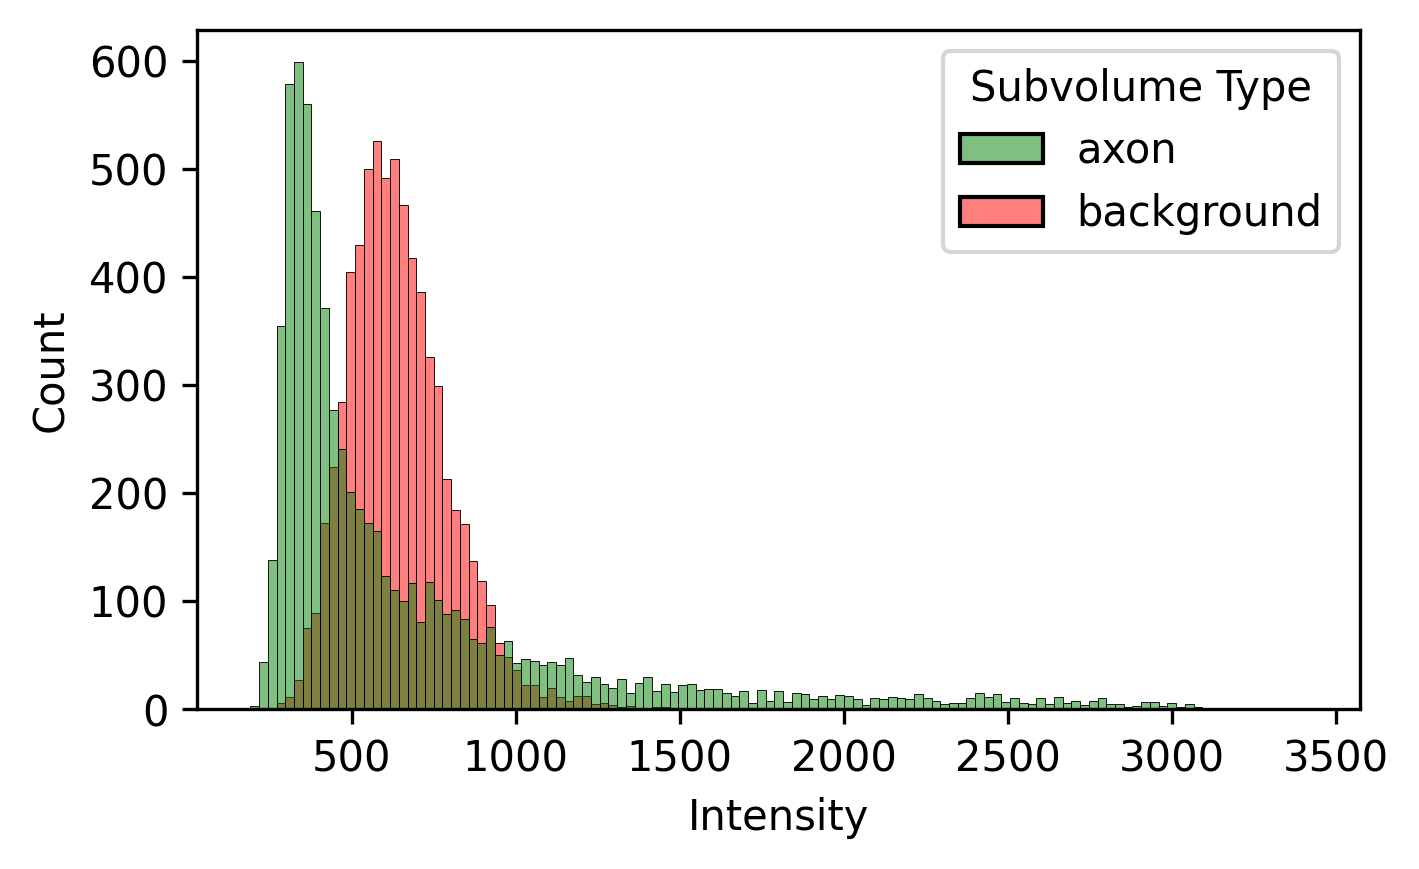

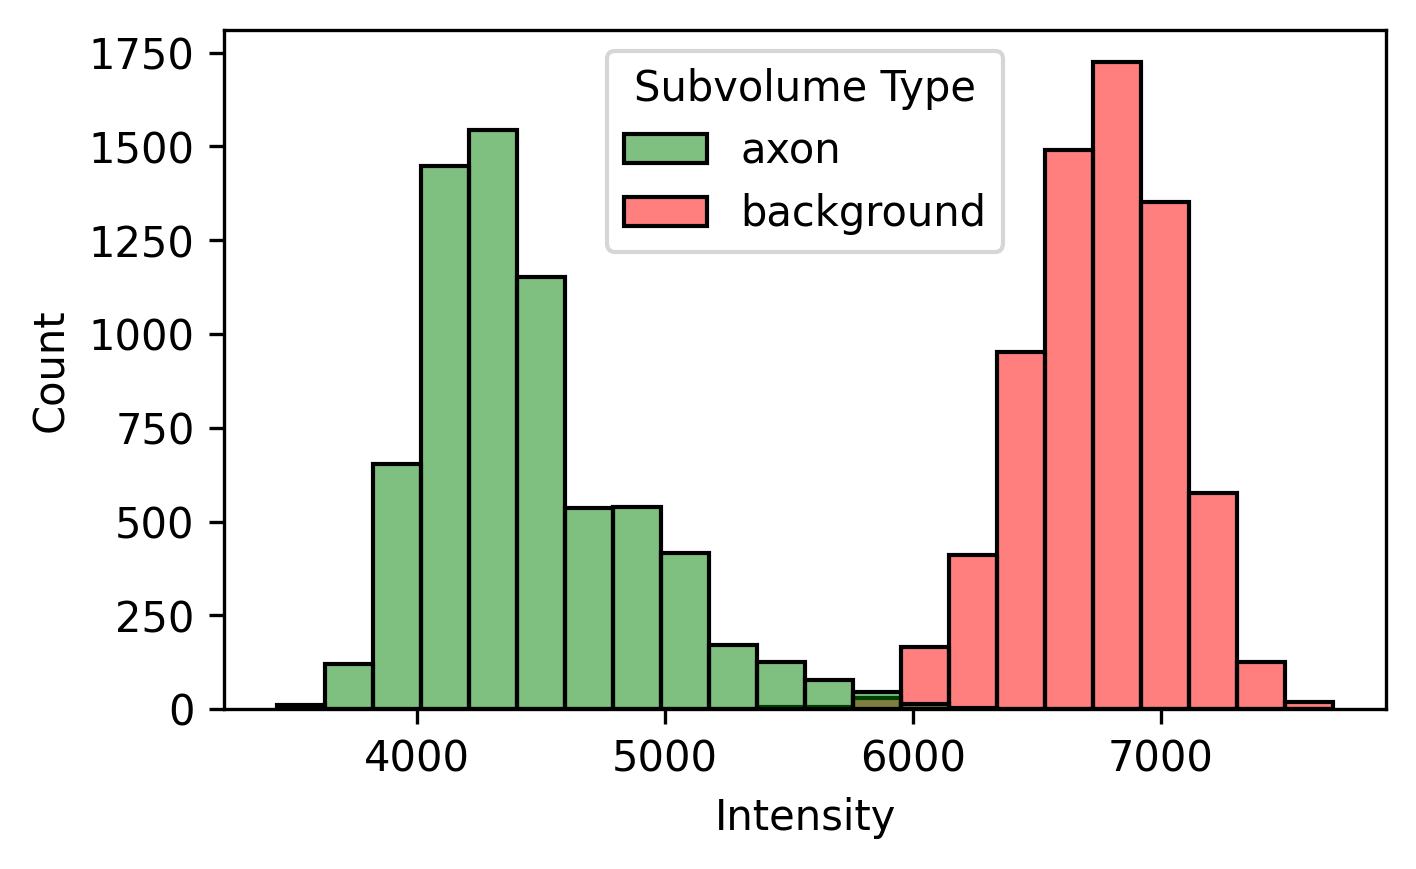

In [37]:
data = {"8649": ([2192, 1244, 1332], [901, 2559, 1332]),"8650": ([2378, 948, 1851], [2302, 5705, 1851]),"8589": ([4312, 4163, 1450], [1335, 6119, 1450]),"8613": ([3911, 3461, 1514], [1411, 5720, 1514]),"8590": ([1394, 1940, 1854], [4776, 816, 1854])} #axon center then nonaxon center

data2 = {}
for i in ["8650", "8589", "8590"]:
    data2[i] = data[i]
data = data2


for i, brain in enumerate(data.keys()):
    vol = CloudVolume(brain2paths_axon[brain]["ab"])
    coord = data[brain][0]
    subvol = vol[coord[0]-9:coord[0]+10, coord[1]-9:coord[1]+10, coord[2]-9:coord[2]+10]
    intensities1 = list(subvol.flatten())
    subvol_types1 = ["axon"] * len(intensities1)


    coord = data[brain][1]
    subvol = vol[coord[0]-9:coord[0]+10, coord[1]-9:coord[1]+10, coord[2]-9:coord[2]+10]
    intensities2 = list(subvol.flatten())
    subvol_types2 = ["background"] * len(intensities2)

    intensities = intensities1 + intensities2
    subvol_types = subvol_types1 + subvol_types2

    df = pd.DataFrame(data = {"Intensity": intensities, "Subvolume Type": subvol_types})

    fig, axes = plt.subplots(1, 1, sharex=True, figsize=(5,3), dpi=300)

    sns.histplot(data=df, x="Intensity", hue="Subvolume Type", ax=axes, palette=['green', 'red']) 

## Accuracy Plots

In [11]:
# training set results
training_brain_order = [3, 4, 8649, 8788]
models = []
for i, brain in enumerate(training_brain_order):
    model = ""
    for j, brain2 in enumerate(training_brain_order[:i+1]):
        model += "-"
        model += str(brain2)
    models.append(model)

sample_ids = {8589: 3, 8590: 4, 8613: 5, 8649: 6, 8650: 7, 8788: 8}

### Plot best f scores

Inventory:
Brains 8589, 8590, 8613, 8649, 8650
models: All single ones, then sequential 8649, 8650, 8589, 8613, 8590
Results: all single ones

Plot idea: Total accuracy over time: need all models to be evaluated on all datasets

In [12]:
brain_order = [8650, 8649, 8613, 8589, 8590, 8788]
models_results = []
fscores = []
brains = []
av_fscores = []

for model_n, model in enumerate(tqdm(models, desc="Cycling through models...")):  
    av_fscore = []    
    for brain in tqdm(brain_order, desc="Evaluating brains..."):
        brain_dir = f"/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brain{brain}/"
        results_dir = brain_dir + "results" + model

        # identify images an split into val and test
        files = find_sample_names(brain_dir, dset = "val", add_dir = False)
        random.shuffle(files)
        half = int(len(files)/2)
        val_files = files[:half]
        test_files = files[half:]

        # val - choose best threshold
        true_files = []
        pred_files = []
        for val_file in val_files:
            true_file = f"{brain_dir}/{val_file.split('.')[0]}-image_2channel_Labels.h5"
            true_files.append(true_file)
            pred_file = f"{results_dir}/{val_file.split('.')[0]}_Probabilities.h5"
            pred_files.append(pred_file)

        spacing = 0.02
        thresholds = np.arange(spacing, 1.0, spacing)
        best_fscore = 0
        best_thresh = -1
        
        for threshold in tqdm(thresholds, desc="searching threshold...", leave=False):
            true_pos_total = 0
            false_pos_total = 0
            true_labels_total = 0

            for true_file, pred_file in zip(true_files, pred_files):
                f = h5py.File(pred_file, "r")
                seg = f.get("exported_data")
                seg = seg[1, :, :, :]
                mask_forward = seg > threshold

                f = h5py.File(true_file, "r")
                gt = f.get("exported_data")
                gt = gt[0, :, :, :]
                pos_labels = gt == 2
                neg_labels = gt == 1

                true_pos = np.sum(np.logical_and(mask_forward, pos_labels))
                true_pos_total += true_pos

                false_pos = np.sum(np.logical_and(mask_forward, gt == 1))
                false_pos_total += false_pos

                true_labels = np.sum(pos_labels)
                true_labels_total += true_labels

            precision_total = true_pos_total / (true_pos_total + false_pos_total)
            recall_total = true_pos_total / true_labels_total
            fscore = 2 / (1 / precision_total + 1 / recall_total)

            if fscore > best_fscore:
                best_fscore = fscore
                best_thresh = threshold

        # test
        true_files = []
        pred_files = []
        for val_file in test_files:
            true_file = f"{brain_dir}/{val_file.split('.')[0]}-image_2channel_Labels.h5"
            true_files.append(true_file)
            pred_file = f"{results_dir}/{val_file.split('.')[0]}_Probabilities.h5"
            pred_files.append(pred_file)

        true_pos_total = 0
        false_pos_total = 0
        true_labels_total = 0

        for true_file, pred_file in zip(true_files, pred_files):
            f = h5py.File(pred_file, "r")
            seg = f.get("exported_data")
            seg = seg[1, :, :, :]
            mask_forward = seg > best_thresh

            f = h5py.File(true_file, "r")
            gt = f.get("exported_data")
            gt = gt[0, :, :, :]
            pos_labels = gt == 2
            neg_labels = gt == 1

            true_pos = np.sum(np.logical_and(mask_forward, pos_labels))
            true_pos_total += true_pos

            false_pos = np.sum(np.logical_and(mask_forward, gt == 1))
            false_pos_total += false_pos

            true_labels = np.sum(pos_labels)
            true_labels_total += true_labels

        precision_total = true_pos_total / (true_pos_total + false_pos_total)
        recall_total = true_pos_total / true_labels_total
        fscore = 2 / (1 / precision_total + 1 / recall_total)

        fscores.append(fscore)
        models_results.append(model_n)
        brains.append(sample_ids[brain])
        
        av_fscore.append(fscore)

    av_fscores.append(np.mean(av_fscore))

Cycling through models...:   0%|          | 0/4 [00:00<?, ?it/s]



















































































































































Cycling through models...:  25%|██▌       | 1/4 [00:16<00:50, 16.79s/it]




































































































































Cycling through models...:  50%|█████     | 2/4 [00:32<00:32, 16.15s/it]






































































































































Cycling through models...:  75%|███████▌  | 3/4 [00:48<00:16, 16.20s/it]

















































































































































Cycling through models...: 100%|██████████| 4/4 [01:05<00:00, 16.49s/it]


[
    <matplotlib.axis.XTick object at 0x166af05b0>,
    <matplotlib.axis.XTick object at 0x16697b820>,
    <matplotlib.axis.XTick object at 0x110ed33d0>,
    <matplotlib.axis.XTick object at 0x166a942e0>
]

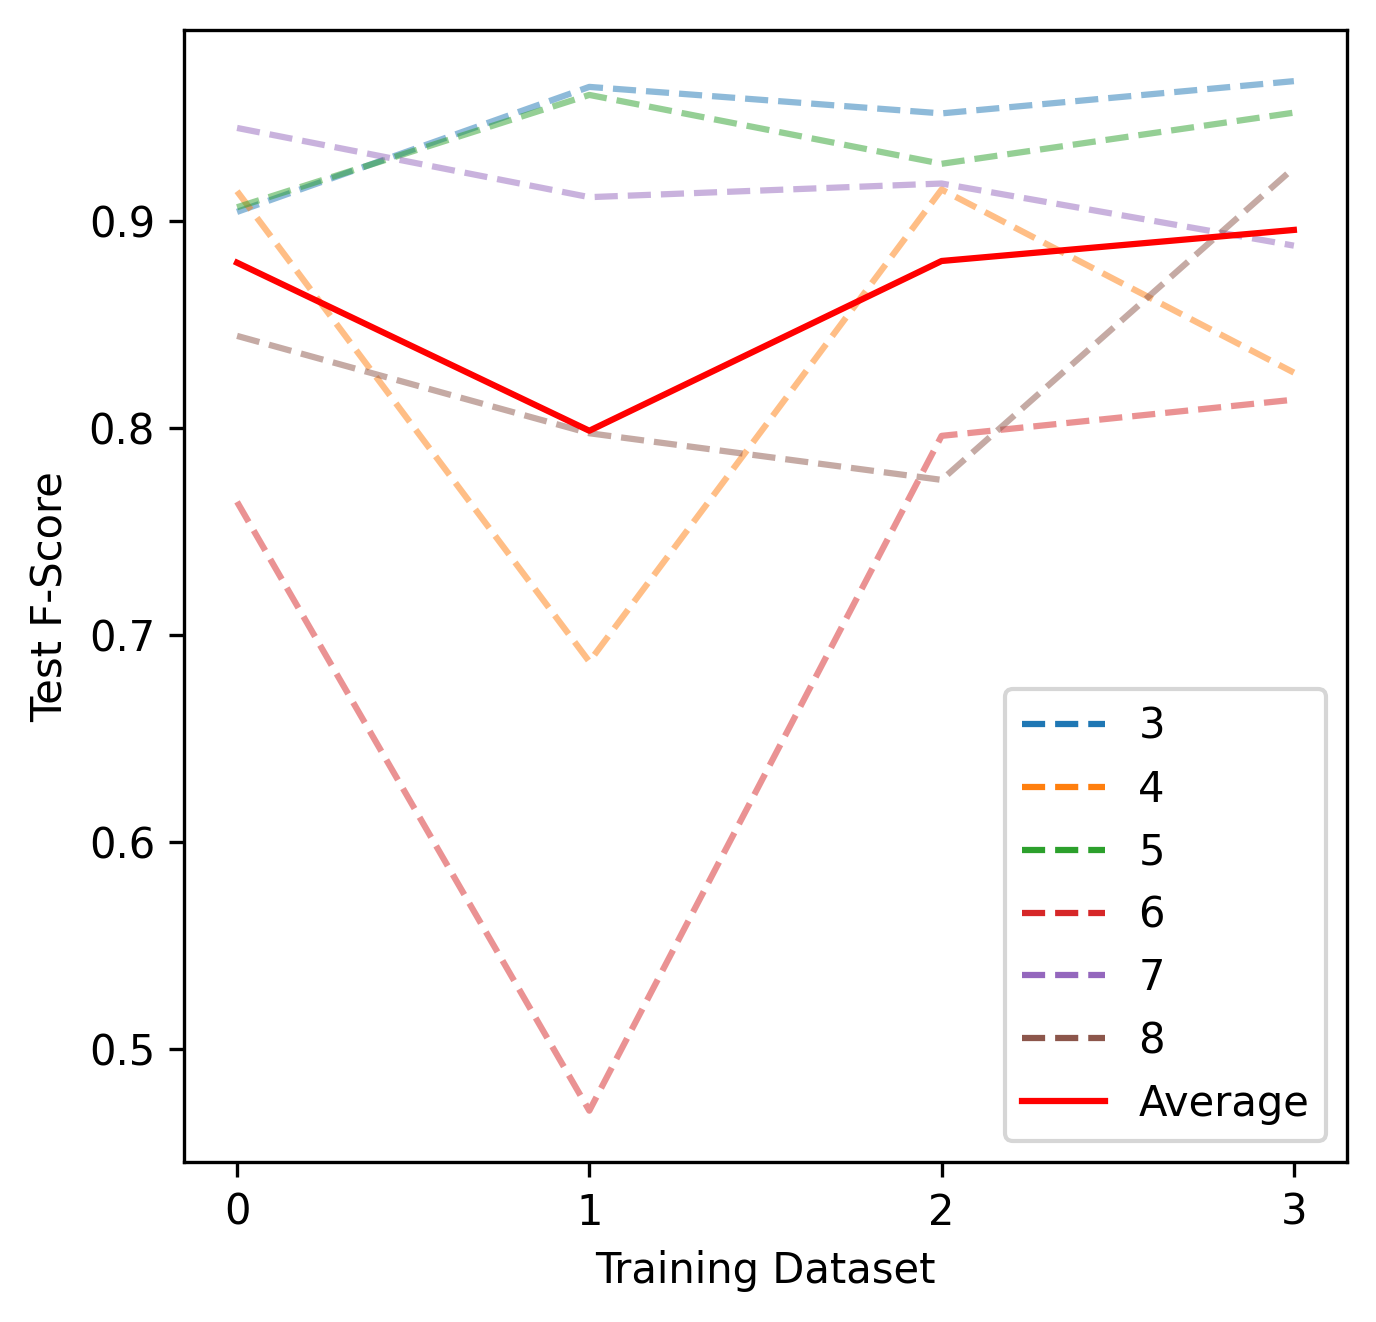

In [13]:
df = pd.DataFrame(data={"Test F-Score": fscores, "Training Dataset": models_results, "Brain": brains})
fig, axes = plt.subplots(1, 1, figsize=(5,5), dpi=300)
sns.lineplot(data=df, x="Training Dataset", y="Test F-Score", hue="Brain", ax=axes, alpha=0.5, linestyle='dashed', palette="tab10")

axes.plot(np.arange(len(models)), av_fscores, color='red', label="Average")
leg = axes.legend(loc='lower right')
leg_lines = leg.get_lines()
for i in range(len(brain_order)): 
    leg_lines[i].set_linestyle("--")
axes.set_xticks(np.arange(len(models)))

## Compare to sample number

In [32]:
# training set results
training_brain_order = [3, 4, 8649, 8788]
models_diff = []
models_same = []

for i, brain in enumerate(training_brain_order):
    model_diff = "-compare"
    for j, brain2 in enumerate(training_brain_order[:i+1]):
        model_diff += "-"
        model_diff += str(brain2)

        model_same = "-compare-3"
        if j > 0:
            model_same += f"_{j+1}"

    models_diff.append(model_diff)
    models_same.append(model_same)

print(f"heterogeneous: {models_diff} homogeneous: {models_same}")

heterogeneous: ['-compare-3', '-compare-3-4', '-compare-3-4-8649', '-compare-3-4-8649-8788'] homogeneous: ['-compare-3', '-compare-3_2', '-compare-3_3', '-compare-3_4']


In [33]:
brain_order = [8650, 8649, 8613, 8589, 8590, 8788]
models_results = []
model_lines = []
fscores = []
brains = []
av_fscores = []

for brain in tqdm(brain_order, desc="Evaluating brains..."):
    brain_dir = f"/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brain{brain}/"
    # identify images an split into val and test
    files = find_sample_names(brain_dir, dset = "val", add_dir = False)
    random.shuffle(files)
    half = int(len(files)/2)
    val_files = files[:half]
    test_files = files[half:]

    for model_line, models in zip(["Heterogenerous", "Homogeneous"],[models_diff, models_same]):
        for model_n, model in enumerate(tqdm(models, desc="Cycling through models...")):     
            results_dir = brain_dir + "results" + model


            # val - choose best threshold
            true_files = []
            pred_files = []
            for val_file in val_files:
                true_file = f"{brain_dir}/{val_file.split('.')[0]}-image_2channel_Labels.h5"
                true_files.append(true_file)
                pred_file = f"{results_dir}/{val_file.split('.')[0]}_Probabilities.h5"
                pred_files.append(pred_file)

            spacing = 0.02
            thresholds = np.arange(spacing, 1.0, spacing)
            best_fscore = 0
            best_thresh = -1
            
            for threshold in tqdm(thresholds, desc="searching threshold...", leave=False):
                true_pos_total = 0
                false_pos_total = 0
                true_labels_total = 0

                for true_file, pred_file in zip(true_files, pred_files):
                    f = h5py.File(pred_file, "r")
                    seg = f.get("exported_data")
                    seg = seg[1, :, :, :]
                    mask_forward = seg > threshold

                    f = h5py.File(true_file, "r")
                    gt = f.get("exported_data")
                    gt = gt[0, :, :, :]
                    pos_labels = gt == 2
                    neg_labels = gt == 1

                    true_pos = np.sum(np.logical_and(mask_forward, pos_labels))
                    true_pos_total += true_pos

                    false_pos = np.sum(np.logical_and(mask_forward, gt == 1))
                    false_pos_total += false_pos

                    true_labels = np.sum(pos_labels)
                    true_labels_total += true_labels

                precision_total = true_pos_total / (true_pos_total + false_pos_total)
                recall_total = true_pos_total / true_labels_total
                fscore = 2 / (1 / precision_total + 1 / recall_total)

                if fscore > best_fscore:
                    best_fscore = fscore
                    best_thresh = threshold

            # test
            true_files = []
            pred_files = []
            for val_file in test_files:
                true_file = f"{brain_dir}/{val_file.split('.')[0]}-image_2channel_Labels.h5"
                true_files.append(true_file)
                pred_file = f"{results_dir}/{val_file.split('.')[0]}_Probabilities.h5"
                pred_files.append(pred_file)

            true_pos_total = 0
            false_pos_total = 0
            true_labels_total = 0

            for true_file, pred_file in zip(true_files, pred_files):
                f = h5py.File(pred_file, "r")
                seg = f.get("exported_data")
                seg = seg[1, :, :, :]
                mask_forward = seg > best_thresh

                f = h5py.File(true_file, "r")
                gt = f.get("exported_data")
                gt = gt[0, :, :, :]
                pos_labels = gt == 2
                neg_labels = gt == 1

                true_pos = np.sum(np.logical_and(mask_forward, pos_labels))
                true_pos_total += true_pos

                false_pos = np.sum(np.logical_and(mask_forward, gt == 1))
                false_pos_total += false_pos

                true_labels = np.sum(pos_labels)
                true_labels_total += true_labels

            precision_total = true_pos_total / (true_pos_total + false_pos_total)
            recall_total = true_pos_total / true_labels_total
            fscore = 2 / (1 / precision_total + 1 / recall_total)

            fscores.append(fscore)
            models_results.append(model_n)
            brains.append(brain)
            
            av_fscore.append(fscore)
            model_lines.append(model_line)


Evaluating brains...:   0%|          | 0/6 [00:00<?, ?it/s]








































































Cycling through models...: 100%|██████████| 4/4 [00:08<00:00,  2.08s/it]








































































Evaluating brains...:  17%|█▋        | 1/6 [00:15<01:18, 15.72s/it]





















































































































Cycling through models...: 100%|██████████| 4/4 [00:20<00:00,  5.10s/it]














































































































Evaluating brains...:  33%|███▎      | 2/6 [00:56<02:00, 30.23s/it]







































































Cycling through models...: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it]








































































Evaluating brains...:  50%|█████     | 3/6 [01:10<01:09, 23.22s/it]





[
    <matplotlib.axis.XTick object at 0x16273d3d0>,
    <matplotlib.axis.XTick object at 0x1617eef40>,
    <matplotlib.axis.XTick object at 0x16156fc70>,
    <matplotlib.axis.XTick object at 0x1627a72b0>
]

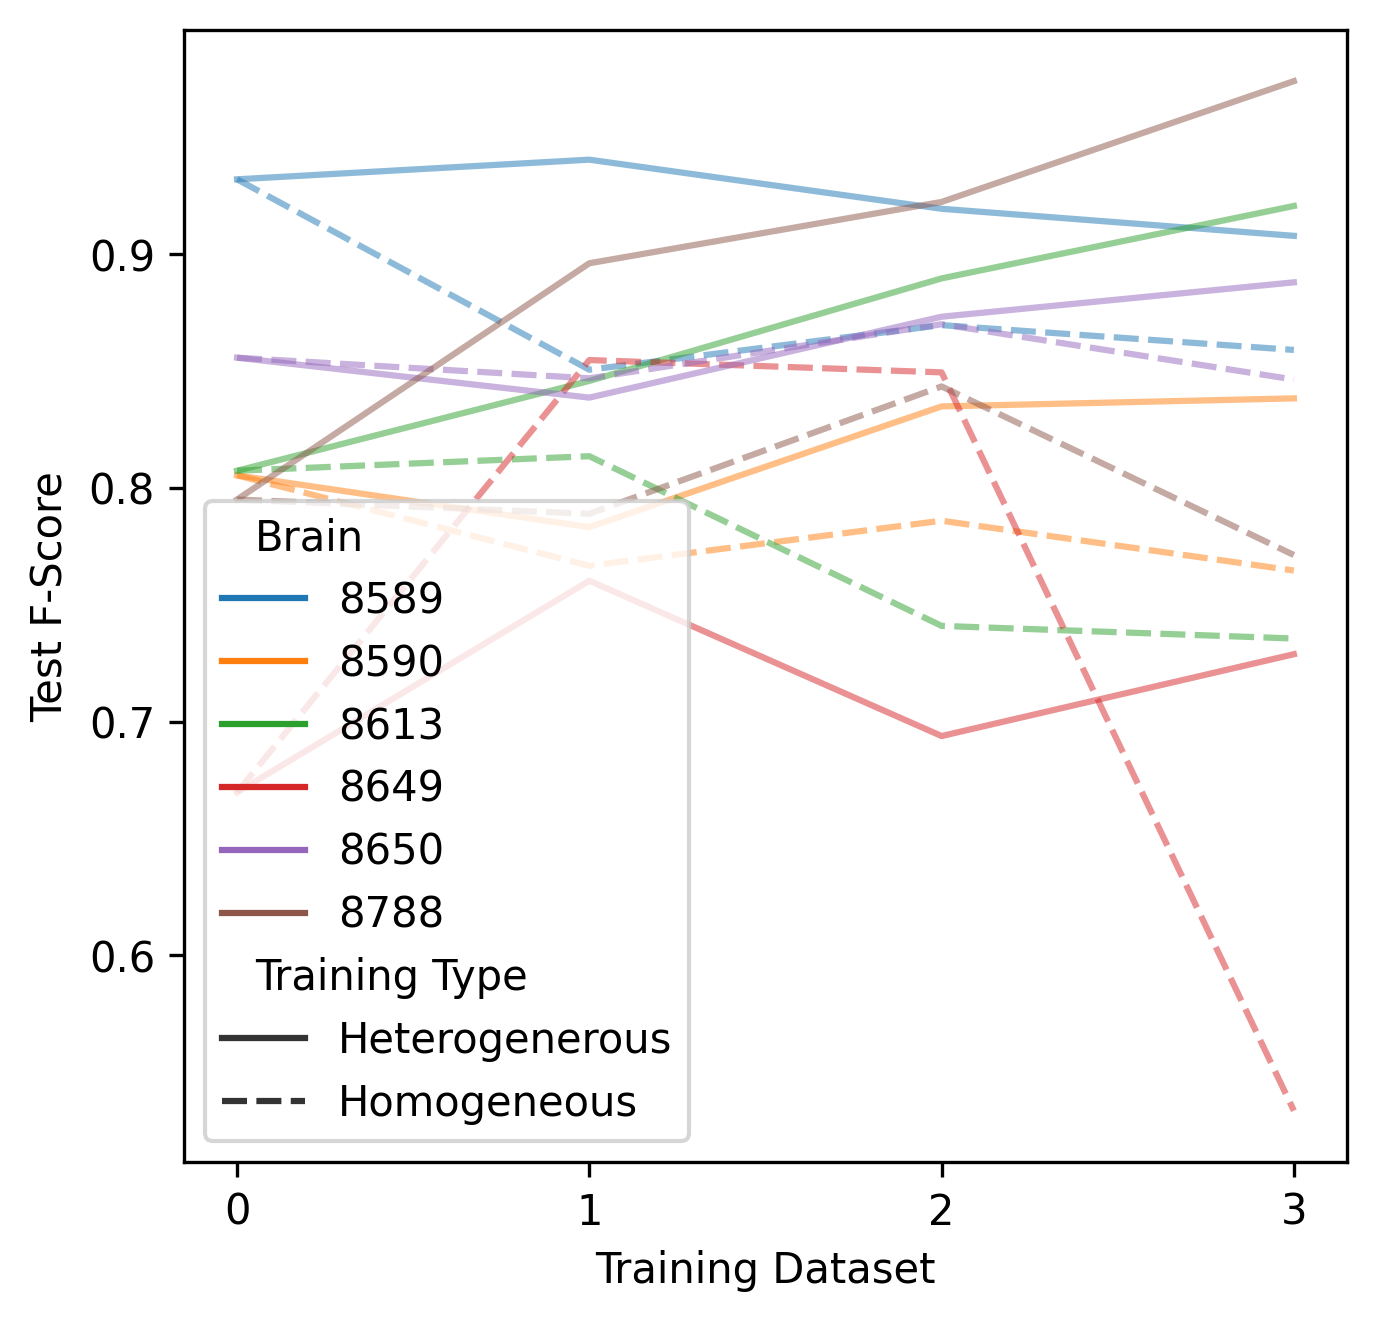

In [34]:
df = pd.DataFrame(data={"Test F-Score": fscores, "Training Dataset": models_results, "Brain": brains, "Training Type": model_lines})
fig, axes = plt.subplots(1, 1, figsize=(5,5), dpi=300)
sns.lineplot(data=df, x="Training Dataset", y="Test F-Score", hue="Brain", style="Training Type", ax=axes, alpha=0.5, linestyle='dashed', palette="tab10")


# axes.plot(np.arange(len(models)), av_fscores, color='red', label="Average")
# leg = axes.legend(loc='lower right')
# leg_lines = leg.get_lines()
# for i in range(len(brain_order)): 
#     leg_lines[i].set_linestyle("--")
axes.set_xticks(np.arange(len(models)))

[
    <matplotlib.axis.XTick object at 0x162963130>,
    <matplotlib.axis.XTick object at 0x162963100>,
    <matplotlib.axis.XTick object at 0x16297a4f0>,
    <matplotlib.axis.XTick object at 0x1629a10a0>
]

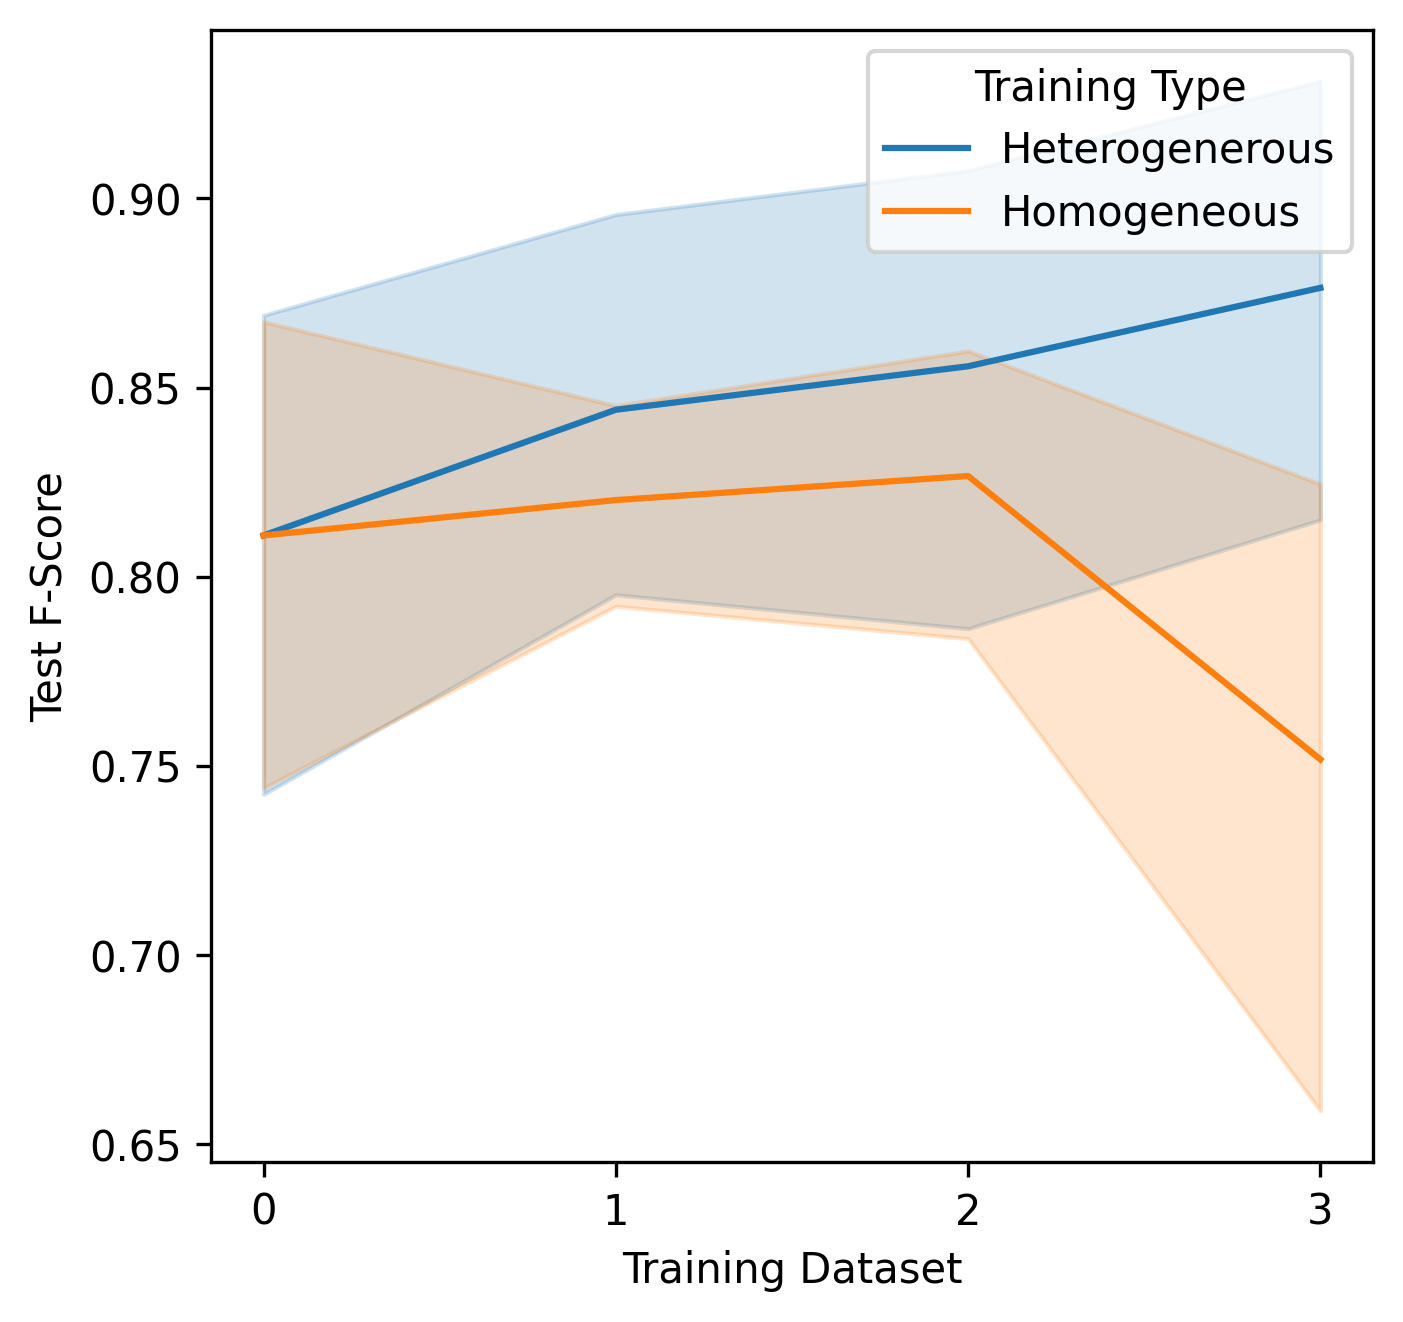

In [37]:
df = pd.DataFrame(data={"Test F-Score": fscores, "Training Dataset": models_results, "Brain": brains, "Training Type": model_lines})
fig, axes = plt.subplots(1, 1, figsize=(5,5), dpi=300)
sns.lineplot(data=df, x="Training Dataset", y="Test F-Score", hue="Training Type")
axes.set_xticks(np.arange(len(models)))

# Other

## Tools

### Randomly choose training set

In [ ]:
base_dir = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/continual-learning/paper-brains/brain8650/"
files = os.listdir(base_dir)
files = [base_dir + f for f in files if ".h5" in f]
l = len(files)
l_train = int(np.ceil(l/2))
random.shuffle(files)
print(files[:l_train])

### Convert labels

In [ ]:
base_dir = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/continual-learning/paper-brains/brain8650/labels/"
files = os.listdir(base_dir)
files = [base_dir + f for f in files if "_Labels" in f]
files = [f for f in files if ".h5" in f]

for file in files:
    with h5py.File(file) as hf:
        labels = np.array(hf['exported_data'])
    io.imsave(file[:-3] + '.tif', labels)

### Move files 

In [ ]:
brain = "8650"
model = "brain3"

base_dir = (
            "/Users/thomasathey/Documents/mimlab/mouselight/ailey/continual-learning/val/brain"
            + brain
            + "/"
        )

files = os.listdir(base_dir)
files = [f for f in files if "_Probabilities" in f]

move = input(f"Rename {files} to {base_dir}{model}? (y/n)")
if move == "y":
    for file in files:
        os.rename(base_dir + file, f"{base_dir}{model}/{file}")

## Forward Learning Efficiency

In [ ]:
lFLEs = []
tasks = np.arange(1, len(brain_order)+1)

for brain in tqdm(brain_order, desc="Evaluating brains..."):
    brain_dir = f"/Users/thomasathey/Documents/mimlab/mouselight/ailey/continual-learning/paper-brains/brain{brain}/"
    trains = training_ids[brain]

    files = os.listdir(brain_dir)
    files = [f for f in files if ".h5" in f]

    val_files = []
    if isinstance(trains[0], str):
        for file in files:
            add = True
            for train in trains:
                if train in file:
                    add = False
                    break
            
            if add:
                val_files.append(file)
    elif isinstance(trains[0], int):
        for file in files:
            file_num = file.split("_")[1]
            file_num = int(file_num.split(".")[0])

            if file_num not in trains:
                val_files.append(file)
    else:
        raise ValueError("Training id's are neither strnigs or ints")


    forward_model = f"results"
    for i, fwd_brain in enumerate(brain_order):
        if i > 0:
            forward_model += "-"
        forward_model += f"{fwd_brain}"

        if fwd_brain == brain:
            break

    true_files = []
    baseline_files = []
    forward_files = []
    for val_file in val_files:
        true_file = f"{brain_dir}labels/{val_file.split('.')[0]}-image_2channel_Labels.h5"
        true_files.append(true_file)
        baseline_file = f"{brain_dir}results{brain}/{val_file.split('.')[0]}_Probabilities.h5"
        baseline_files.append(baseline_file)
        forward_file = f"{brain_dir}{forward_model}/{val_file.split('.')[0]}_Probabilities.h5"
        forward_files.append(forward_file)


    # Baseline
    spacing = 0.02
    thresholds = np.arange(spacing, 1.0, spacing)
    best_fscore_base = 0
    best_fscore_fwd = 0
    
    for threshold in tqdm(thresholds, desc="searching threshold...", leave=False):
        true_pos_total_base = 0
        true_pos_total_fwd = 0
        false_pos_total_base = 0
        false_pos_total_fwd = 0
        true_labels_total = 0

        for true_file, baseline_file, forward_file in zip(true_files, baseline_files, forward_files):
            f = h5py.File(baseline_file, "r")
            seg = f.get("exported_data")
            seg = seg[1, :, :, :]
            mask_base = seg > threshold

            f = h5py.File(forward_file, "r")
            seg = f.get("exported_data")
            seg = seg[1, :, :, :]
            mask_forward = seg > threshold

            f = h5py.File(true_file, "r")
            gt = f.get("exported_data")
            gt = gt[0, :, :, :]
            pos_labels = gt == 2
            neg_labels = gt == 1

            true_pos = np.sum(np.logical_and(mask_base, pos_labels))
            true_pos_total_base += true_pos
            true_pos = np.sum(np.logical_and(mask_forward, pos_labels))
            true_pos_total_fwd += true_pos

            false_pos = np.sum(np.logical_and(mask_base, gt == 1))
            false_pos_total_base += false_pos
            false_pos = np.sum(np.logical_and(mask_forward, gt == 1))
            false_pos_total_fwd += false_pos

            true_labels = np.sum(pos_labels)
            true_labels_total += true_labels


        precision_total_base = true_pos_total_base / (true_pos_total_base + false_pos_total_base)
        recall_total_base = true_pos_total_base / true_labels_total
        fscore_base = 2 / (1 / precision_total_base + 1 / recall_total_base)

        precision_total_fwd = true_pos_total_fwd / (true_pos_total_fwd + false_pos_total_fwd)
        recall_total_fwd = true_pos_total_fwd / true_labels_total
        fscore_fwd = 2 / (1 / precision_total_fwd + 1 / recall_total_fwd)

        if fscore_base > best_fscore_base:
            best_fscore_base = fscore_base
        if fscore_fwd > best_fscore_fwd:
            best_fscore_fwd = fscore_fwd
    lFLEs.append(np.log((1-best_fscore_base)/(1-best_fscore_fwd)))
        



In [ ]:
methods = ["Total Replay" for t in tasks]
data = {"Task": tasks, "log Forward LE": lFLEs, "Resource Growing": methods}
df = pd.DataFrame(data=data)
sns.lineplot(data=df, x="Task", y="log Forward LE", hue = "Resource Growing")
plt.xticks(tasks, tasks)

## Backward Learning Efficiency

In [ ]:
lBLEs = []
tasks = []
dsets = []

for brain1_id, brain1 in enumerate(tqdm(brain_order, desc="Evaluating brains...")):
    brain_dir = f"/Users/thomasathey/Documents/mimlab/mouselight/ailey/continual-learning/paper-brains/brain{brain1}/"
    trains = training_ids[brain1]

    files = os.listdir(brain_dir)
    files = [f for f in files if ".h5" in f]

    val_files = []
    if isinstance(trains[0], str):
        for file in files:
            add = True
            for train in trains:
                if train in file:
                    add = False
                    break
            
            if add:
                val_files.append(file)
    elif isinstance(trains[0], int):
        for file in files:
            file_num = file.split("_")[1]
            file_num = int(file_num.split(".")[0])

            if file_num not in trains:
                val_files.append(file)
    else:
        raise ValueError("Training id's are neither strnigs or ints")

    # Intermediate datasets
    for brain2_id, brain2 in enumerate(tqdm(brain_order[brain1_id:], desc="Iterating through intermediate datasets...", leave=False)):
        backward_model = f"results"
        for i, fwd_brain in enumerate(brain_order[:brain2_id+brain1_id+1]):
            if i > 0:
                backward_model += "-"
            backward_model += f"{fwd_brain}"

            if fwd_brain == brain:
                break

        true_files = []
        backward_files = []
        for val_file in val_files:
            true_file = f"{brain_dir}labels/{val_file.split('.')[0]}-image_2channel_Labels.h5"
            true_files.append(true_file)
            backward_file = f"{brain_dir}{backward_model}/{val_file.split('.')[0]}_Probabilities.h5"
            backward_files.append(backward_file)


        # Baseline
        spacing = 0.02
        thresholds = np.arange(spacing, 1.0, spacing)
        best_fscore_back = 0
        
        for threshold in tqdm(thresholds, desc="searching threshold...", leave=False):
            true_pos_total_back = 0
            false_pos_total_back = 0
            true_labels_total = 0

            for true_file, backward_file in zip(true_files, backward_files):
                f = h5py.File(backward_file, "r")
                seg = f.get("exported_data")
                seg = seg[1, :, :, :]
                mask_back = seg > threshold

                f = h5py.File(true_file, "r")
                gt = f.get("exported_data")
                gt = gt[0, :, :, :]
                pos_labels = gt == 2
                neg_labels = gt == 1

                true_pos = np.sum(np.logical_and(mask_back, pos_labels))
                true_pos_total_back += true_pos

                false_pos = np.sum(np.logical_and(mask_back, gt == 1))
                false_pos_total_back += false_pos

                true_labels = np.sum(pos_labels)
                true_labels_total += true_labels


            precision_total_back = true_pos_total_back / (true_pos_total_back + false_pos_total_back)
            recall_total_back = true_pos_total_back / true_labels_total
            fscore_back = 2 / (1 / precision_total_back + 1 / recall_total_back)

            if fscore_back > 1:
                raise ValueError(f"Invalid f score: base {precision_total_back}, {recall_total_back} -> {fscore_back}")

            if fscore_back > best_fscore_back:
                best_fscore_back = fscore_back
        if brain2 == brain1:
            best_fscore_base = best_fscore_back


        tasks.append(brain1_id)
        dsets.append(brain2_id+brain1_id)  
        lBLEs.append(np.log((1-best_fscore_base)/(1-best_fscore_back)))
        



In [ ]:
methods = ["Total Replay" for t in tasks]
data = {"Task": tasks, "log Backward LE": lBLEs, "Training Dataset": dsets}
df = pd.DataFrame(data=data)
sns.lineplot(data=df, x="Training Dataset", y="log Backward LE", hue="Task")
plt.xticks(tasks, tasks)

## Verify Training

In [ ]:
f = h5py.File("/Users/thomasathey/Documents/mimlab/mouselight/ailey/continual-learning/paper-brains/test/val_2_Probabilities_full.h5", "r")
seg = f.get("exported_data")
seg_full = seg[1, :, :, :]

f = h5py.File("/Users/thomasathey/Documents/mimlab/mouselight/ailey/continual-learning/paper-brains/test/val_2_Probabilities.h5", "r")
seg = f.get("exported_data")
seg_seq = seg[1, :, :, :]

## PR Curves

In [ ]:
brains = ["8650", "8649", 
    "8613", "8589", "8590"]

model_names = ["brain8649", "brain8649-3", "brain3-4-8649"] #["brain3", "brain3-4", "brain3-4-8649"]

brain_ids = []
precisions = []
recalls = []
models = []

best_precisions = []
best_recalls = []
best_fscores = {}

for model in model_names: 
    for brain in brains:

        base_dir = (
            "/Users/thomasathey/Documents/mimlab/mouselight/ailey/continual-learning/val/brain"
            + brain
            + "/"
        )

        spacing = 0.02
        thresholds = np.arange(spacing, 1.0, spacing)
        best_fscore = 0

        files = os.listdir(base_dir)
        files = [f for f in files if "val" in f]
        files = [f for f in files if "_Labels.h5" not in f]
        files = [f for f in files if "_Probabilities.h5" not in f]

        print(f"{len(files)} total validation subvolumes for brain {brain}")

        for threshold in thresholds:
            true_pos_total = 0
            false_pos_total = 0
            true_labels_total = 0
            true_labels_total_neg = 0
            for fname in files:
                fname_im = base_dir + fname
                f = h5py.File(fname_im, "r")
                im = f.get("image_2channel")
                im_bg = im[0, :, :, :]
                im_fg = im[1, :, :, :]

                fname_prob = f"{base_dir}{model}/{fname[:-3]}_Probabilities.h5"
                f = h5py.File(fname_prob, "r")
                seg = f.get("exported_data")
                seg = seg[1, :, :, :]
                mask = seg > threshold

                fname_lab = f"{base_dir}labels/{fname[:-3]}-image_2channel_Labels.h5" 
                f = h5py.File(fname_lab, "r")
                gt = f.get("exported_data")
                gt = gt[0, :, :, :]
                pos_labels = gt == 2
                neg_labels = gt == 1

                true_pos = np.sum(np.logical_and(mask, pos_labels))
                true_pos_total += true_pos
                false_pos = np.sum(np.logical_and(mask, gt == 1))
                false_pos_total += false_pos
                true_labels = np.sum(pos_labels)
                true_labels_total += true_labels
                true_labels_neg = np.sum(neg_labels)
                true_labels_total_neg += true_labels_neg

            precision_total = true_pos_total / (true_pos_total + false_pos_total)
            recall_total = true_pos_total / true_labels_total

            precisions.append(precision_total)
            recalls.append(recall_total)
            brain_ids.append(brain)
            models.append(model)

            fscore = 2 / (1 / precision_total + 1 / recall_total)

            if fscore > best_fscore:
                best_fscore = fscore
                best_prec = precision_total
                best_recall = recall_total
                best_threshold = threshold
        best_precisions.append(best_prec)
        best_recalls.append(best_recall)
        best_fscores[brain] = best_fscore

for i, brain_id in enumerate(brain_ids):
    brain_ids[i] = brain_id + f" - Max F-score: {best_fscores[brain_id]:.2f}"

data = {"Sample": brain_ids, "Recall": recalls, "Precision": precisions, "Model": models}
df = pd.DataFrame(data=data)


sns.set(rc={"figure.figsize": (10, 7)})
sns.set(font_scale=2)
sns.lineplot(data=df, x="Recall", y="Precision", hue="Sample", style="Model")
sns.scatterplot(x=best_recalls, y=best_precisions)

## Change of max f score

In [ ]:
brains = ["8650", "8649", 
    "8613", "8589", "8590"]

model_names = ["brain3", "brain3-4", "brain3-4-8649"]

brain_ids = []
best_fscores = []
models = []

best_precisions = []
best_recalls = []
best_fscores_dict = {}

for model in model_names: 
    for brain in brains:

        base_dir = (
            "/Users/thomasathey/Documents/mimlab/mouselight/ailey/continual-learning/val/brain"
            + brain
            + "/"
        )

        spacing = 0.02
        thresholds = np.arange(spacing, 1.0, spacing)
        best_fscore = 0

        files = os.listdir(base_dir)
        files = [f for f in files if "val" in f]
        files = [f for f in files if "_Labels.h5" not in f]
        files = [f for f in files if "_Probabilities.h5" not in f]

        print(f"{len(files)} total validation subvolumes for brain {brain}")

        for threshold in thresholds:
            true_pos_total = 0
            false_pos_total = 0
            true_labels_total = 0
            true_labels_total_neg = 0
            for fname in files:
                fname_im = base_dir + fname
                f = h5py.File(fname_im, "r")
                im = f.get("image_2channel")
                im_bg = im[0, :, :, :]
                im_fg = im[1, :, :, :]

                fname_prob = f"{base_dir}{model}/{fname[:-3]}_Probabilities.h5"
                f = h5py.File(fname_prob, "r")
                seg = f.get("exported_data")
                seg = seg[1, :, :, :]
                mask = seg > threshold

                fname_lab = f"{base_dir}labels/{fname[:-3]}-image_2channel_Labels.h5" 
                f = h5py.File(fname_lab, "r")
                gt = f.get("exported_data")
                gt = gt[0, :, :, :]
                pos_labels = gt == 2
                neg_labels = gt == 1

                true_pos = np.sum(np.logical_and(mask, pos_labels))
                true_pos_total += true_pos
                false_pos = np.sum(np.logical_and(mask, gt == 1))
                false_pos_total += false_pos
                true_labels = np.sum(pos_labels)
                true_labels_total += true_labels
                true_labels_neg = np.sum(neg_labels)
                true_labels_total_neg += true_labels_neg

            precision_total = true_pos_total / (true_pos_total + false_pos_total)
            recall_total = true_pos_total / true_labels_total

            fscore = 2 / (1 / precision_total + 1 / recall_total)

            if fscore > best_fscore:
                best_fscore = fscore
                best_prec = precision_total
                best_recall = recall_total
                best_threshold = threshold
        best_fscores.append(best_fscore)
        brain_ids.append(brain)
        models.append(model)

        best_fscores_dict[brain] = best_fscore

for i, brain_id in enumerate(brain_ids):
    brain_ids[i] = brain_id + f" - Max F-score: {best_fscores_dict[brain_id]:.2f}"

data = {"Sample": brain_ids, "Best F-score": best_fscores, "Model": models}
df = pd.DataFrame(data=data)

sns.set(rc={"figure.figsize": (20, 10)})
sns.set(font_scale=2)
sns.catplot(data=df, x="Model", y="Best F-score", hue="Sample", kind="point", height=7)

In [ ]:

sns.set(rc={"figure.figsize": (20, 10)})
sns.set(font_scale=2)
sns.catplot(data=df, x="Model", y="Best F-score", hue="Sample", kind="point", height=7)

# Soma

## Intensity data

Downloading: 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]


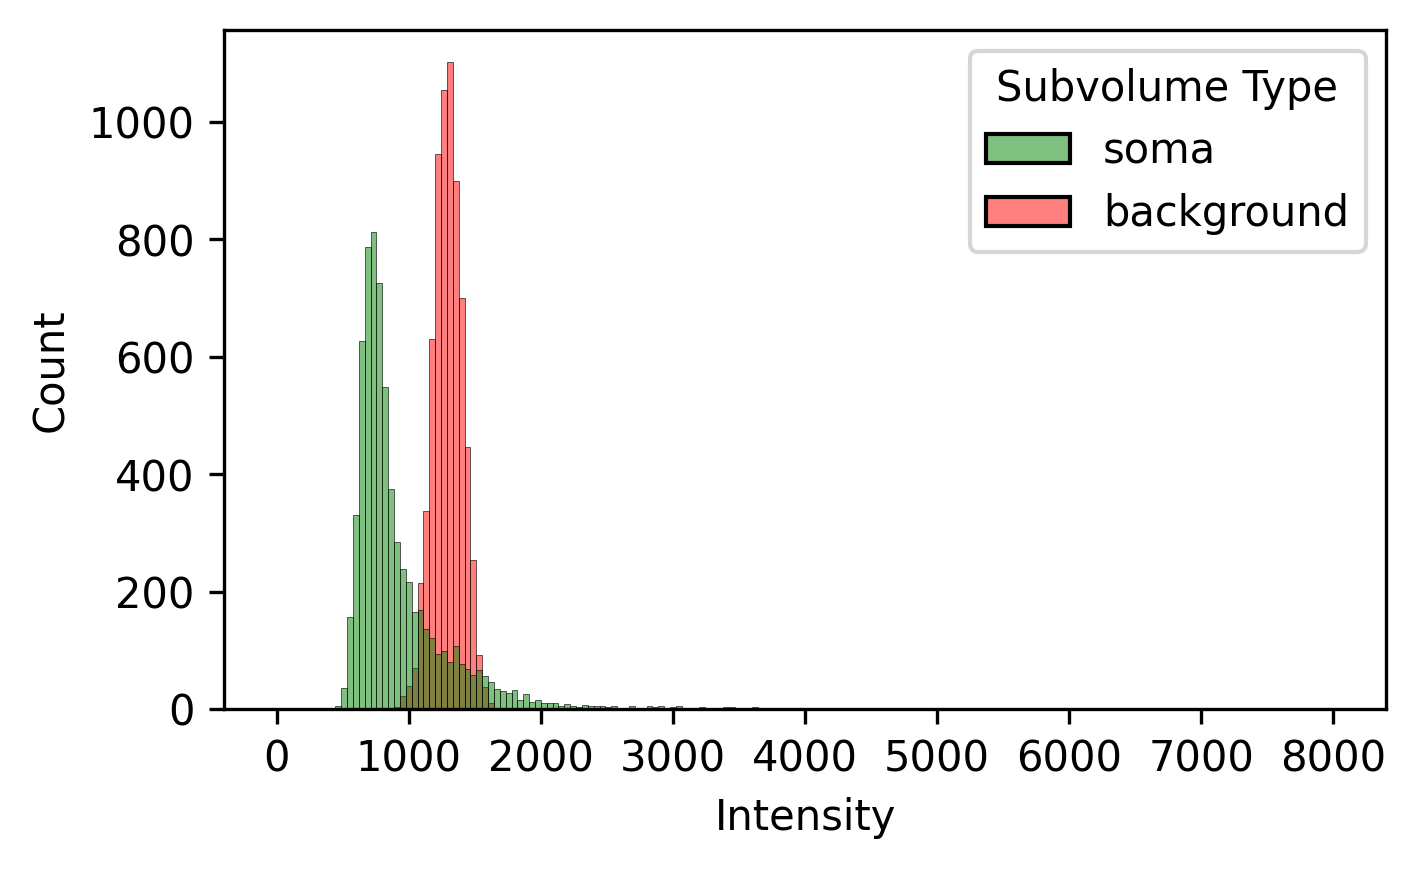

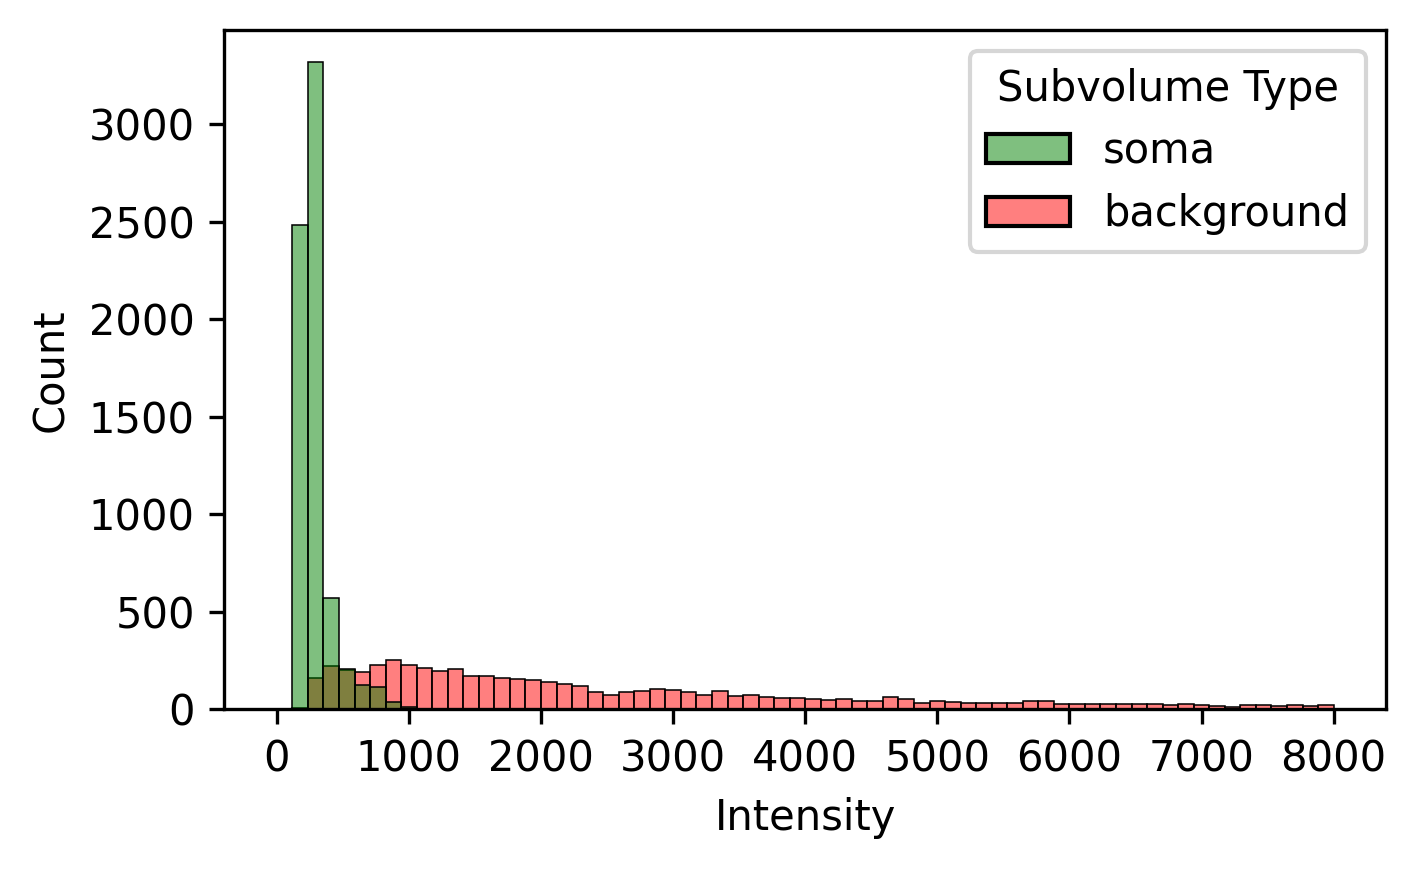

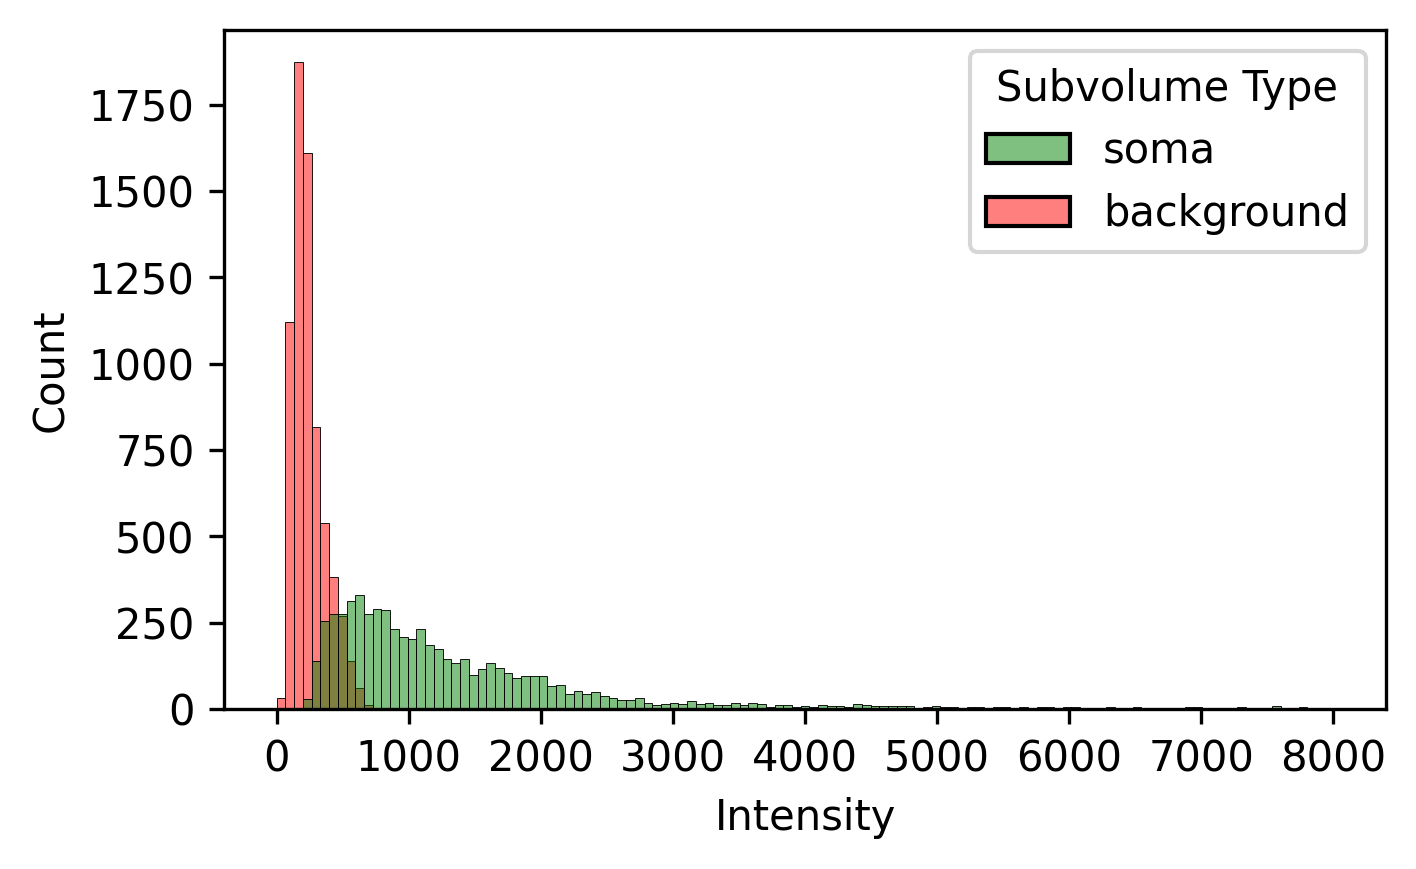

In [38]:
data = {"8606": ([1726, 2619, 1687], [3071, 4360, 1687]),"8446": ([1979, 3491, 1791], [1258, 3502, 1791]),"887": ([3537, 3787, 1385], [2088, 1924, 1385])} # soma center then nonsoma center



for i, brain in enumerate(data.keys()):
    vol = CloudVolume(brain2paths_soma[brain]["ab"])
    coord = data[brain][0]
    subvol = vol[coord[0]-9:coord[0]+10, coord[1]-9:coord[1]+10, coord[2]-9:coord[2]+10]
    intensities1 = list(subvol.flatten())
    subvol_types1 = ["soma"] * len(intensities1)


    coord = data[brain][1]
    subvol = vol[coord[0]-9:coord[0]+10, coord[1]-9:coord[1]+10, coord[2]-9:coord[2]+10]
    intensities2 = list(subvol.flatten())
    subvol_types2 = ["background"] * len(intensities2)

    intensities = intensities1 + intensities2
    subvol_types = subvol_types1 + subvol_types2

    df = pd.DataFrame(data = {"Intensity": intensities, "Subvolume Type": subvol_types})
    fig, axes = plt.subplots(1, 1, sharex=True, figsize=(5,3), dpi=300)
    sns.histplot(data=df, x="Intensity", hue="Subvolume Type", ax=axes, palette=['green', 'red'], binrange=(0,8000))


## Plot test results

In [30]:
# training set results
brain_order = ["r1", "r2", "878", "887"]
brains = [8607, 8606, 8477, 8531, 8608, 8529, 8557, 8555, 8446, 8454, 887]
models = []
for i, brain in enumerate(brain_order):
    model = "results"
    for j, brain2 in enumerate(brain_order[:i+1]):
        if j > 0:
            model += "_"
        model += str(brain2)
    models.append(model)

print(models)

size_thresh = 500
doubles = ["3972_1636_1575_pos_Probabilities.h5", "2867_4336_1296_pos_Probabilities.h5", "2607_1845_1309_pos_Probabilities.h5",
"2101_3397_1747_pos_Probabilities.h5", "2011_3452_1911_pos_Probabilities.h5", "2113_3353_1727_pos_Probabilities.h5", "1968_3472_1784_pos_Probabilities.h5"] #8446


sample_ids = {b : i+2 for i, b in enumerate(np.sort(brains))}
print(f"sample ids: {sample_ids}")

['resultsr1', 'resultsr1_r2', 'resultsr1_r2_878', 'resultsr1_r2_878_887']


In [31]:
models_results = []
fscores = []
brains_results = []
av_fscores = []

for model_n, model in enumerate(tqdm(models, desc="Cycling through models...")):
    av_fscore = []  
    for brain in tqdm(brains, desc="Evaluating brains..."):
        if brain == 8557:
            brain_name = "r1"
        elif brain == 8555:
            brain_name = "r2"
        else:
            brain_name = brain

        images_dir = f"/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/brain{brain_name}/3channel/test/images_only/"
        results_dir = f"/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/brain{brain_name}/3channel/test/{model}/"
        files = find_sample_names(images_dir, dset = "", add_dir = False)
        files = [r[:-3] + "_Probabilities.h5" for r in files]

        reshuffle = True
        while reshuffle:
            random.shuffle(files)
            half = int(len(files)/2)
            val_files = files[:half]
            test_files = files[half:]
            for val_file in val_files:
                if "pos" in val_file:
                    for test_file in test_files:
                        if "pos" in test_file:
                            reshuffle=False
                            break
                    
                    break

        
        # Baseline
        spacing = 0.02
        thresholds = np.arange(spacing, 1.0, spacing)
        best_fscore = 0
        best_thresh = -1
        
        for threshold in tqdm(thresholds, desc="searching threshold...", leave=False, disable=True):
            tot_pos = 0
            true_pos = 0
            false_pos = 0

            for results_file in val_files:
                if results_file in doubles:
                    newpos = 2
                else:
                    newpos = 1

                f = h5py.File(results_dir+results_file, "r")
                seg = f.get("exported_data")
                seg = seg[0, :, :, :]
                mask = seg > threshold
                labels = measure.label(mask)
                props = measure.regionprops(labels)

                if "pos" in results_file:
                    num_detected = 0
                    tot_pos += newpos
                    for prop in props:
                        if prop["area"] > size_thresh:
                            if num_detected < newpos:
                                true_pos += 1
                                num_detected += 1
                            else:
                                false_pos += 1
                elif "neg" in results_file:
                    for prop in props:
                        if prop["area"] > size_thresh:
                            false_pos += 1


            recall = true_pos / tot_pos
            if true_pos + false_pos == 0:
                precision = 0
            else:
                precision = true_pos / (true_pos + false_pos)
                
            if precision == 0 and recall == 0:
                fscore = 0
            else:
                fscore = 2 * precision * recall / (precision + recall)

            if fscore > best_fscore:
                best_fscore = fscore
                best_thresh = threshold

        true_pos = 0
        false_pos = 0
        tot_pos = 0

        for results_file in test_files:
            if results_file in doubles:
                newpos = 2
            else:
                newpos = 1

            f = h5py.File(results_dir+results_file, "r")
            seg = f.get("exported_data")
            seg = seg[0, :, :, :]
            mask = seg > best_thresh
            labels = measure.label(mask)
            props = measure.regionprops(labels)

            if "pos" in results_file:
                num_detected = 0
                tot_pos += newpos
                for prop in props:
                    if prop["area"] > size_thresh:
                        if num_detected < newpos:
                            true_pos += 1
                            num_detected += 1
                        else:
                            false_pos += 1
            elif "neg" in results_file:
                for prop in props:
                    if prop["area"] > size_thresh:
                        false_pos += 1


        recall = true_pos / tot_pos
        if true_pos + false_pos == 0:
            precision = 0
        else:
            precision = true_pos / (true_pos + false_pos)
            
        if precision == 0 and recall == 0:
            fscore = 0
        else:
            fscore = 2 * precision * recall / (precision + recall)
        
        av_fscore.append(fscore)
        fscores.append(fscore)
        models_results.append(model_n)
        brains_results.append(sample_ids[brain])

    av_fscores.append(np.mean(av_fscore))

Cycling through models...: 100%|██████████| 4/4 [01:46<00:00, 26.52s/it]


[
    <matplotlib.axis.XTick object at 0x166f8b760>,
    <matplotlib.axis.XTick object at 0x166f8b730>,
    <matplotlib.axis.XTick object at 0x166fa0880>,
    <matplotlib.axis.XTick object at 0x166fc0f70>
]

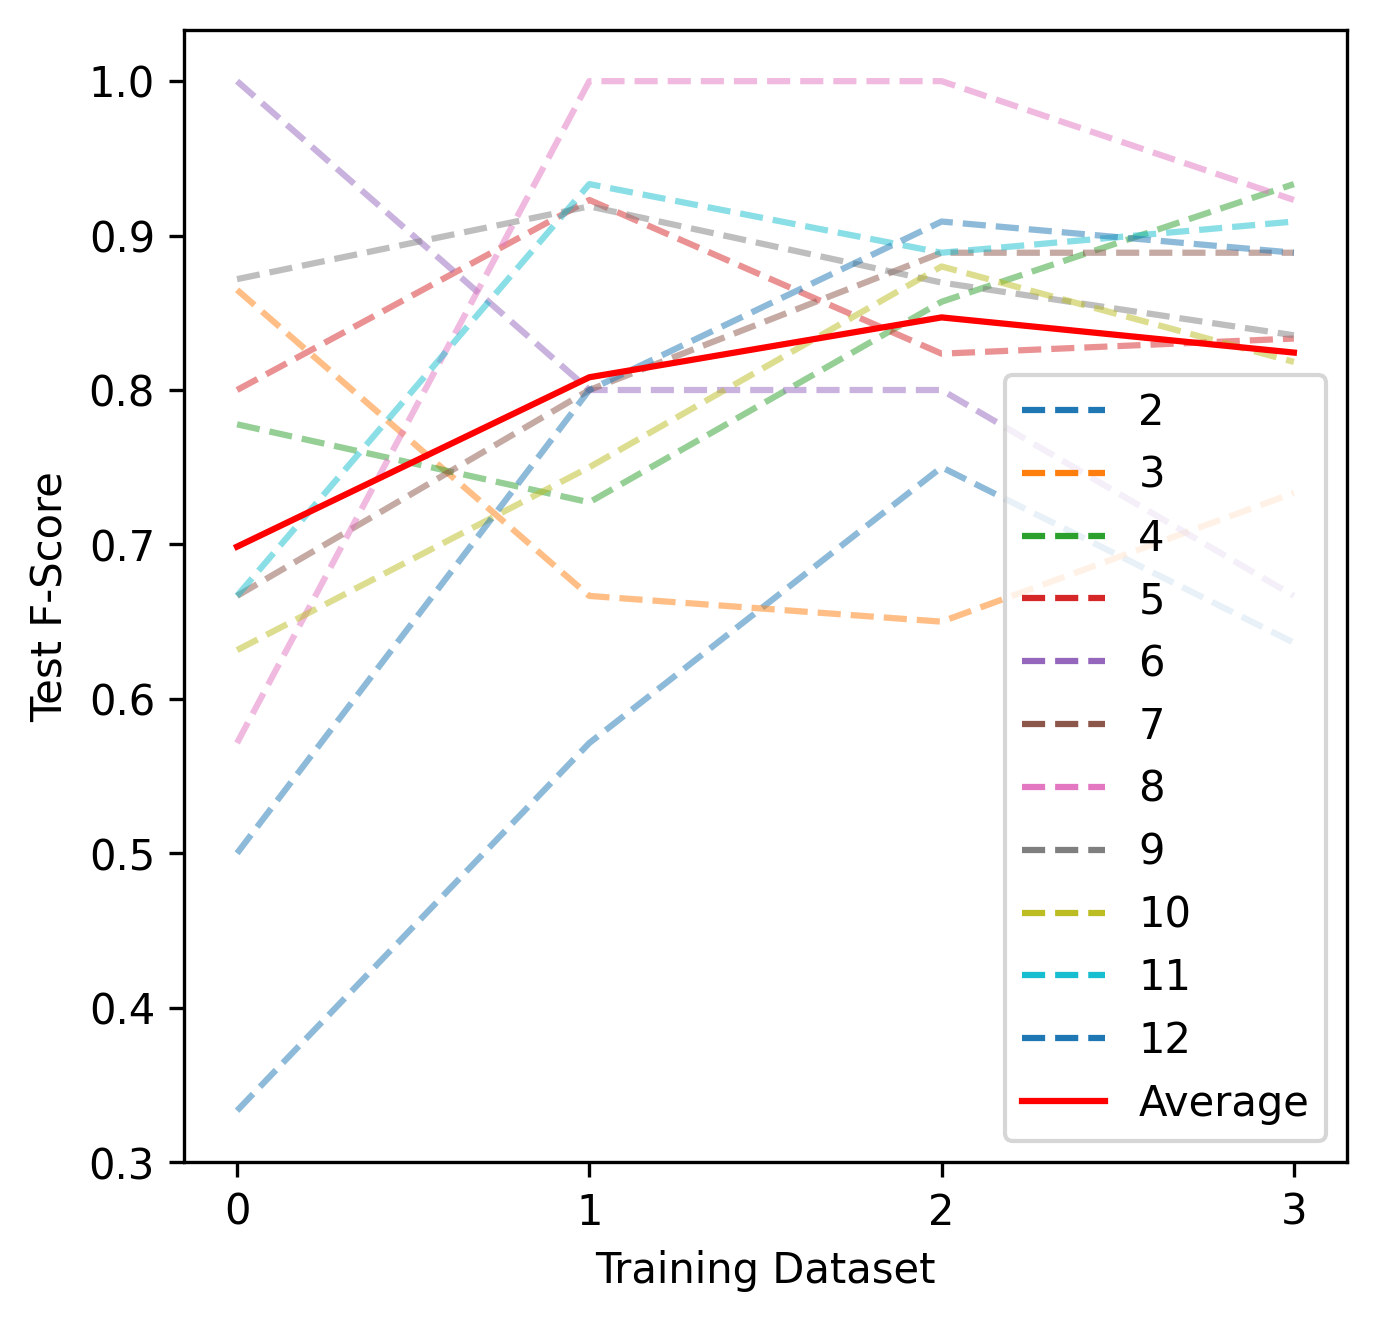

In [32]:
df = pd.DataFrame(data={"Test F-Score": fscores, "Training Dataset": models_results, "Brain": brains_results})
fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi=300)

sns.lineplot(data=df, x="Training Dataset", y="Test F-Score", hue="Brain", ax=ax, linestyle='dashed', alpha=0.5, palette="tab10")
ax.plot(np.arange(len(models)), av_fscores, color='red', label="Average")
leg = ax.legend(loc='lower right')
leg_lines = leg.get_lines()
for i in range(len(brains)): 
    leg_lines[i].set_linestyle("--")
    
ax.set_xticks(np.arange(len(models)))
